In [47]:
### Imports and Initial Model Setup ###
import time
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from pyDOE import lhs
import scipy
import matplotlib.pyplot as plt
start_time = None 

# Linear interpolation function
def LinearDelay(Y, state, t):
    t_delay = max(0, t)
    L2 = np.searchsorted(Y.history[:, 0], t_delay, side='left')
    L1 = L2 - 1

    Y1 = Y.history[L1, state + 1]
    t1 = Y.history[L1, 0]
    Y2 = Y.history[L2, state + 1]
    t2 = Y.history[L2, 0]

    state_delay = Y1 + (t_delay - t1) * (Y2 - Y1) / (t2 - t1)
    state_delay = np.clip(state_delay, a_min=0.0, a_max=None)
    return state_delay

# StateHistory class for storing state histories
class StateHistory:
    def __init__(self, init_state):
        self.history = np.hstack([0, init_state])
        self.history = np.vstack([self.history, self.history])

    def update(self, t, y):
        new_entry = np.hstack([t, y])
        self.history = np.vstack([self.history, new_entry])

def evalModel(funx, p, y0, t_span, state_labels,
              t_eval=None, p_fit=None, p_fit_labels=None, state_corrections=None):
    
    state_history = StateHistory(y0)
    p_local = p.copy()

    # Update parameters if p_fit is provided
    if p_fit is not None:
        try:
            normal_p_fit = dict(zip(p_fit_labels, 10**p_fit))
        except:
            normal_p_fit = {p_fit_labels, 10**p_fit}
        for key, val in normal_p_fit.items():
            p_local[key] = val

    ode_opts = {'method': 'LSODA'}
    
    # Reset start_time before each solve_ivp call
    global start_time 
    start_time = None
    try:
        # Use ode_opts to unpack options
        sol = solve_ivp(funx, t_span, y0, t_eval=t_eval, 
                        args=(p_local, state_labels, state_history), **ode_opts)

    except TimeoutError:
        print('Timeout error in ODE solver.')
        return None
    except RuntimeError:
        print('Runtime error in ODE solver.')
        return None

    # Apply corrections if provided
    if state_corrections is not None:
        for state, correction in state_corrections.items():
            # Ensure the state exists in the state_labels
            if state in state_labels:

                state_idx = state_labels.index(state)
                print('state', state, 'id', state_idx, 'corr', correction)
                print(np.shape(sol.y))
                sol.y[state_idx, :] += np.float64(correction)

    # Clip the solution to avoid log of values below 1
    sol.y = sol.y.clip(min=1.0)

    return sol

# ODE Plotting
def plot_solution(sol, ax, state, states, color, x_ticks):
    ODE_idx = states.index(state)  # Find index of the state in the ODE solution
    ax.plot(sol.t, np.log10(sol.y[ODE_idx, :].clip(min=1.0)), color=color)  # Plot each state
    ax.set_title(', '.join(state))  # Set title to be a comma-separated list of states
    ax.set_xlabel('Days Post Infection')
    log_string = 'log10(' + state +')'
    ax.set_ylabel(log_string)
    ax.set_xticks(x_ticks)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)
  
#  plotting for ODE solutions and data
def ModelPlotting(sol, t_span, include, figsize=(10,10), data=None, states=None):
    x_ticks = np.arange(0, t_span[-1], 2)  # x-ticks on 2-day intervals
    n_subplots = len(include)  # Determine the number of subplots required from states size

    # Determine the number of rows and columns required for a roughly square subplot grouping
    n_rows = int(np.ceil(np.sqrt(n_subplots)))
    n_cols = int(np.ceil(n_subplots / n_rows))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)  # Create a figure with the required number of rows and columns

    axs = [axs] if not hasattr(axs, 'flatten') else axs.flatten()
    x_ticks = np.arange(0, t_span[-1], 2) 

    for i, state in enumerate(include):
        ax = axs[min(i, len(axs)-1)]  

        plot_solution(sol, ax, state, states, 'black', x_ticks)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        if j < len(axs):
            axs[j].axis('off')

    if data is not None:
        data_setup = [
            {'State': 'V', 'ODE_State': 'V'},
            {'State': 'IL6', 'ODE_State': 'IL6'},
            {'State': 'GMCSF', 'ODE_State': 'GMCSF'},
            {'State': 'TNFA', 'ODE_State': 'TNFA'},
            {'State': 'N', 'ODE_State': 'N'},
            {'State': 'MI', 'ODE_State': 'MI'},
            {'State': 'CD8TE', 'ODE_State': 'Total_T'},
        ]
        for col in data_setup:
            state_col = col['State']
            if state_col in data.columns:  # Ensure the column exists in the data
                state_data = data[[state_col, 'DAY']].copy()  # Select both the state and DAY columns

                # Group by DAY and calculate mean and std
                group_by_day = state_data.groupby('DAY')
                mean_values = group_by_day[state_col].mean()
                std_values = group_by_day[state_col].std()

                ax = axs[include.index(col['ODE_State'])]  # Select corresponding ODE plot axis
                
                # Plot the mean as black edged boxes with white center fill
                ax.scatter(mean_values.index, mean_values, edgecolor='black',
                           facecolor='white', marker='s', label='Mean', zorder=25)

                # Plot the standard deviation limits with capped error bars
                ax.errorbar(mean_values.index, mean_values, yerr=std_values, fmt='none',
                            ecolor='black', capsize=5, label='Std Dev', zorder=20)

    plt.tight_layout()
    plt.show()

    return fig, axs

# Generates LHS spaced parameter sets (LHS maintained per parameter!)
def generate_parameters(n_beacons, fit_parameters, bounds):
    num_parameters = fit_parameters.shape[0]  # Number of parameters
    sample = np.zeros((n_beacons, num_parameters))

    for i in range(num_parameters):
        lb = bounds.lb[i]
        ub = bounds.ub[i]
        param_range = ub - lb
        sample[:, i] = lhs(1, samples=n_beacons).flatten()
        sample[:, i] = lb + sample[:, i] * param_range

    parameter_map = np.clip(sample, -9, 9) # Ensure all values are within the hard bounds
    return parameter_map

state IL6 id 7 corr 9.39
(17, 466)
state GMCSF id 8 corr 10.28
(17, 466)
state TNFA id 9 corr 8.37
(17, 466)
state MI id 11 corr 11499
(17, 466)
state N id 10 corr 250034
(17, 466)
state Total_T id 14 corr 421899
(17, 466)


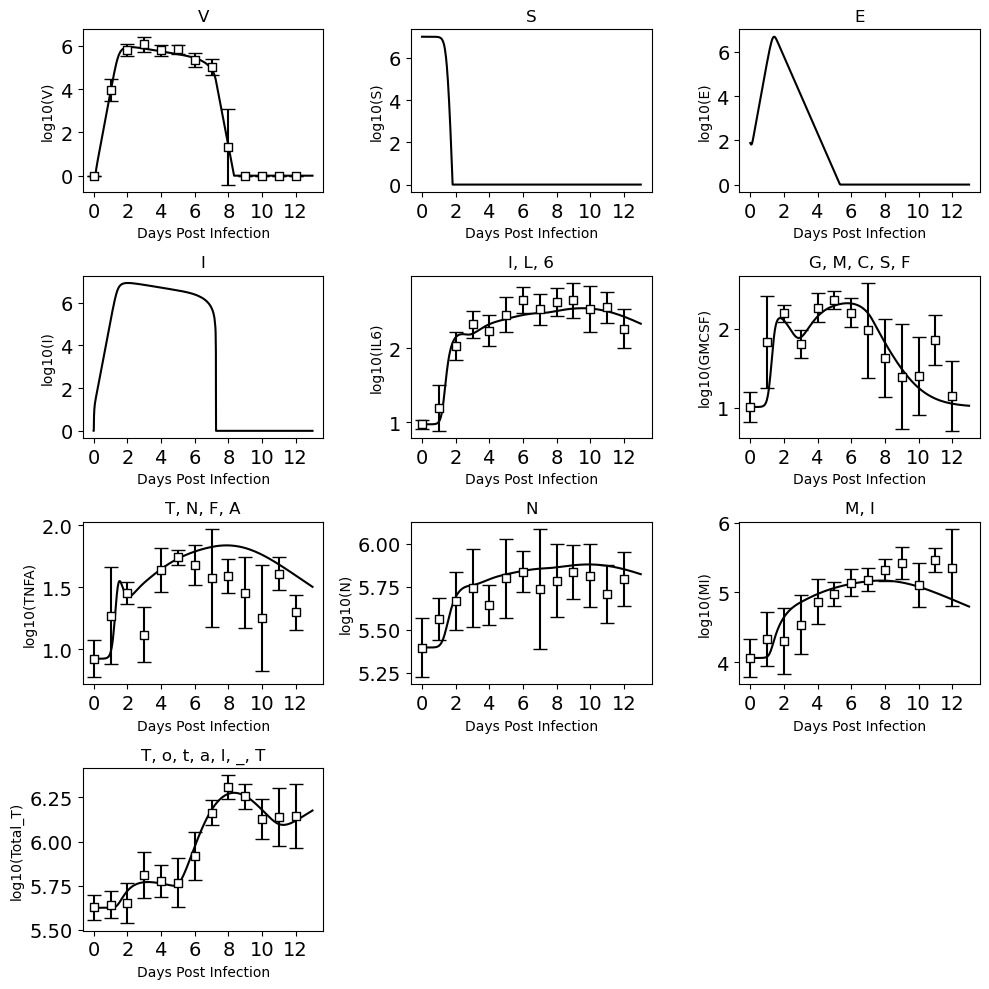

In [48]:
# ## Monolith ###
def Model(t, y, p, state_labels, state_history, timeout=10):
    global start_time 
    if start_time is None:
        start_time = time.time()
        
    elapsed_time = time.time() - start_time
    if elapsed_time > timeout:
        raise TimeoutError("ODE Solver took >", elapsed_time, 'seconds. Aborting.')
    
    # Remove negative states arising from complex roots
    y = y.clip(min=0.0)

    state_history.update(t,y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))

    # Define a list of tuples for each delay. Each tuple contains the delay parameter, the state index and the new variable name
    delays = [('tau_CFA', 'I', 'I_tau_CFA'), 
               ('tau_FB', 'E', 'I_tau_FB'), 
               ('tau_FA', 'E', 'I_tau_FA'), 
               ('tau_CFB', 'E', 'E_tau_CFB'), 
               ('tau_GMCSF', 'MI', 'MI_tau_GMCSF'), 
               ('tau_IL6', 'MI', 'MI_tau_IL6'), 
               ('tau_T', 'I', 'I_tau_T'), 
               ('tau_TM', 'T', 'T_tau_TM')]

    # Use a dictionary comprehension to create each delayed variable
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t-p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    ### Pathogen ###
    dV =  p['p_V_I'] * s['I'] - p['d_V'] * s['V'] - 0 * p['delta_V_MI'] * s['MI'] #- p['delta_V_N'] * s['N'] # (Influenza) Virus

    ### Host Epithelial Cells ###
    dS = - p['p_E_V'] * s['S'] * s['V'] # Susceptible Cells
    dE = p['p_E_V'] * s['S'] * s['V'] - p['p_I_E'] * s['E'] # Eclipse Cells
    dI =  p['p_I_E'] * s['E']  - p['d_I'] * s['I'] - p['delta_I_T'] * s['T'] * s['I']/(p['K_I_T'] + s['I']) # Infected Cells
    dD = p['d_I'] * s['I'] + p['delta_I_T'] * s['T'] * s['I']/(p['K_I_T'] + s['I']) # Dead Cells

    ### Cytokines and Chemokines ###
    dFA =  0#p['p_FA_I'] * s_tau['I_tau_FA'] + 0*p['p_FA_CFA'] * s['CFA'] - p['d_FA'] * s['FA'] # IFNA
    dFB =  p['p_FB_I'] * s_tau['I_tau_FB']  + 0*p['p_FB_CFB'] * s['CFB'] - p['d_FB'] * s['FB'] # IFNB
    dIL6 = p['p_IL6_I'] * s['I'] + p['p_IL6_MI'] * s_tau['MI_tau_IL6'] - p['d_IL6'] * s['IL6'] # IL-6
    dGMCSF = p['p_GMSCF_E'] * s['E'] + p['p_GMCSF_MI'] * s['I']/1E7 * s_tau['MI_tau_GMCSF'] - p['d_GMCSF'] * s['GMCSF'] # GM-CSF
    dTNFA = p['p_TNFA_E'] * s['E'] + p['p_TNFA_MI'] * s['MI'] - p['d_TNFA'] * s['TNFA'] # TNFA

    ### Immune Cells
    dN = (p['p_N_IL6'] * s['IL6']) / (s['N'] + p['eps_N']) - p['d_N'] * s['N'] # Neutrophils
    dMI = p['p_MI_GMCSF'] * s['GMCSF'] / (p['eps_MI'] + s['GMCSF']) - p['d_MI'] * s['MI'] # Inflammatory Macrophages
    dT = (p['p_T_I1'] * s['I']) / (p['K_T_I'] + s['T']) + p['p_T_I2'] * s_tau['I_tau_T'] * s['T'] - p['d_T'] * s['T'] # CD8+ T Cells
    dTM = p['p_TM_T'] * s_tau['T_tau_TM'] # T Memory Cells
    dTotal_T = dT + dTM # Total T Cells
    dCFA = 0#p['p_CFA_I'] * s_tau['I_tau_CFA'] - p['d_CFA'] * s['CFA'] # IFNA Positive Cells
    dCFB = p['p_CFB_E'] * s_tau['E_tau_CFB'] - p['d_CFB'] * s['CFB'] # IFNB Positive Cells

    dydt = dV, dS, dE, dI, dD, dFA, dFB, dIL6, dGMCSF, dTNFA, dN, dMI, dT, dTM, dTotal_T, dCFA, dCFB
    
    return dydt

df_data = pd.read_excel('../Data/Murine Data.xlsx', sheet_name='Dynamics') # Load murine homogenized lung data
Pathogen = ['V'] # Pathogen label(s)
Host = ['S', 'E', 'I', 'D'] # Host Epithelial Cell States
Cyto = ['FA', 'FB', 'IL6', 'GMCSF', 'TNFA'] # Cytokines, Chemokines
Immune = ['N', 'MI', 'T', 'TM', 'Total_T', 'CFA', 'CFB'] # Immune Cells
state_labels = Pathogen + Host + Cyto + Immune # Combined list of all states
t_span = [0, 13] # What timespan should the integration be performed over?

t_censor = 17.5 # Censor data with time > t_censor. Set t_censor = -1 to disable.
if t_censor > 0:
    df_data = df_data[df_data['DAY'] <= t_censor]

y0 = np.zeros(len(state_labels)) # Initial Conditions for ODEs
y0[state_labels.index('S')] = 1E7 # Host Size estimate
y0[state_labels.index('E')] = 75 # Initially 75 eclipse cells

df_par_Complete = pd.read_excel('parameters/parameters_Complete.xlsx',sheet_name='py') # parameter import
parameters = dict(zip(df_par_Complete.labels, df_par_Complete.initval)) #Pack all ODE parameters into a dict. #TODO Explore less verbose alternatives to dicts that retain orderless property.

# Define a dictionary with states and corresponding corrections
state_corrections = {
    'IL6': 9.39, 'GMCSF': 10.28, 'TNFA': 8.37,
    'MI': 11499, 'N': 250034, 'Total_T': 421899
}

# Dictionary of [model state string][floor, ceiling] for plotting ylim changes
ylims_dict = {'Total_T': [4.5, 7.0]} 

ode_opts={
    'method': 'LSODA',
    'rtol': 1e-4,'atol': 1e-4,
    'min_step':1e-5, 'max_step':1e-1
}

plot_labels = ['V', 'E', 'I', 'Total_T', 'FA', 'FB'] # Which data should be plotted?

sol = evalModel(Model, parameters, y0, t_span, state_labels, state_corrections=state_corrections)

# Plot the result
fig, axs = ModelPlotting(sol, t_span, 
                         include=['V', 'S', 'E', 'I', 'IL6', 'GMCSF', 'TNFA','N', 'MI', 'Total_T'],
                         data=df_data, states=state_labels)